In [1]:
import numpy as np
import pandas as pd
import pyLDAvis
import regex
from konlpy.tag import Kkma, Okt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jinma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jinma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

(1) [\ufeff 대책](https://m.blog.naver.com/PostView.nhn?blogId=swkim4610&logNo=221412571868&proxyReferer=https:%2F%2Fwww.google.com%2F)

In [4]:
args = (43,)

In [5]:
files = [f'{i+1}.txt' for i in range(*args)]
docs_ko = []


def read_file(filename, encoding):
    def replace_(s):
        return s.replace('\n', ' ').replace('  ', ' ')
    with open(filename, encoding=encoding) as f:
        res = replace_("".join(f.readlines()))
    return res


for file in files:
    # \ufeff 대책 - (1)
    try:
        docs_ko.append(read_file('data/' + file, 'utf-8-sig'))
    except:
        docs_ko.append(read_file('data/' + file, 'cp949'))

In [6]:
docs = '\n'.join(docs_ko)

In [7]:
from collections import Counter

okt = Okt()
Counter(okt.pos(docs)).most_common(10)

[(('.', 'Punctuation'), 1202),
 (('을', 'Josa'), 866),
 (('이', 'Josa'), 620),
 (('에', 'Josa'), 492),
 (('것', 'Noun'), 484),
 ((',', 'Punctuation'), 466),
 (('의', 'Josa'), 433),
 (('들', 'Suffix'), 369),
 (('가', 'Josa'), 274),
 (('은', 'Josa'), 259)]

In [8]:
stopwords = ['것', '수', '그', '나', '때', '이', '더', '난',
             '을', '에', '으로', '곳', '나', '교', '도', '임',
             '기', '번', '내', '더', '있다', '없다', '어떻다', 
             '같다', '그러하다', '있기', '있는', '하다', '했을', 
             '할', '하는', '있을', '있다는', '이었다', '되었다',
             '있었다', '했다', '한다', '한', '하려고', '않았다',
             '그러하지만', '않지만', '였다고', '했지만','하실지','대한',
             '.', ',']

In [9]:
# 추가 한국어 불용어 사전 추가
from bs4 import BeautifulSoup
# from urllib.request import urlopen
import requests

soup = BeautifulSoup(
#     urlopen('https://www.ranks.nl/stopwords/korean').read(),
    requests.get('https://www.ranks.nl/stopwords/korean', verify=False).text,
    'html.parser'
)

res = []
cache = False
word = []
for s in str(soup.table.tr):
    if s == '>':
        cache = True
        continue
    if s == '<':
        cache = False
        word = ''.join(word)
        if word not in ['', '\n']:
            res.append(word)
        word = []
        continue
    if cache is True:
        word.append(s)

C:\Users\jinma\AppData\Local\Continuum\anaconda3\envs\basic\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [10]:
# Add stopwords
stopwords += res

In [11]:
len(stopwords), len(list(set(stopwords)))

(726, 631)

In [12]:
stopwords = list(set(stopwords))

In [13]:
tokens = [i for i in okt.pos(docs)
 if (
     (i[0] not in stopwords) and
     (i[1] not in  ['Josa', 'Foreign', 'Punctuation'])
 )
]

In [14]:
path = r'C:\Windows\Fonts\malgun.ttf'

from matplotlib import font_manager, rc

font_name=font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

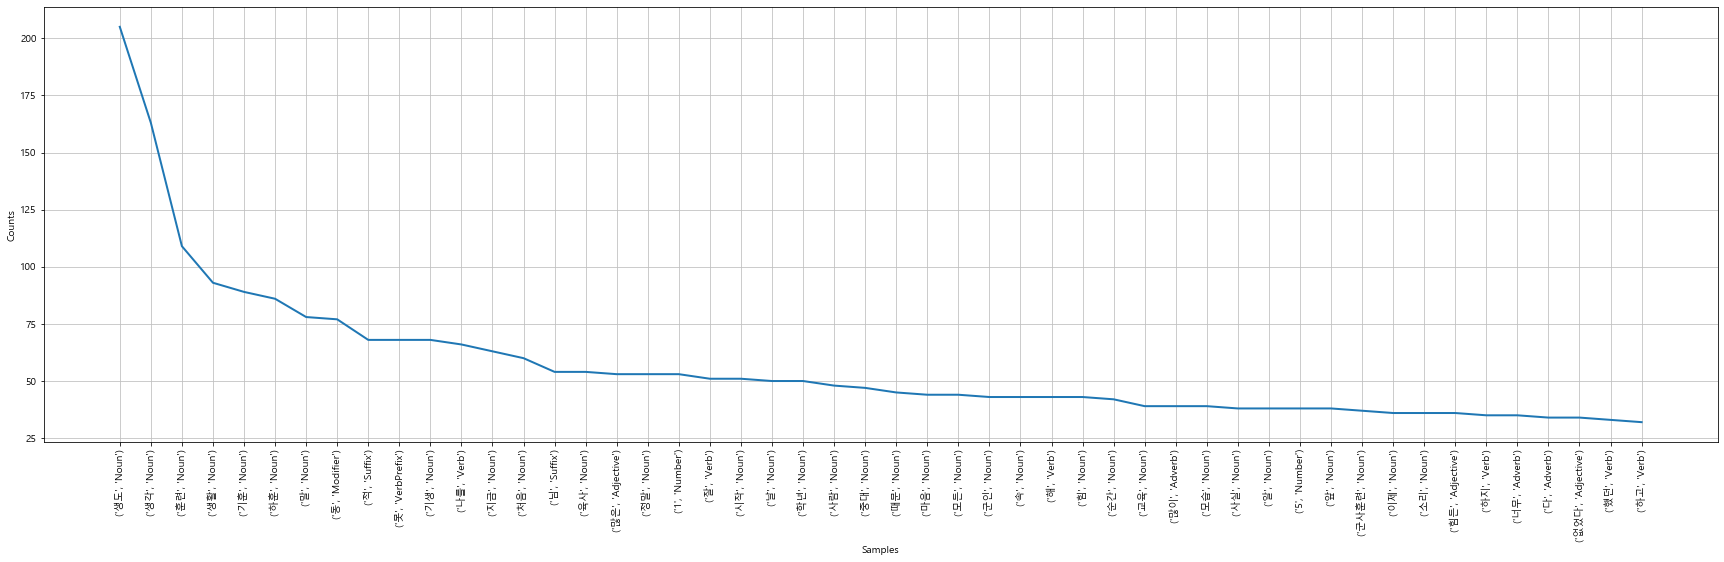

In [15]:
plt.figure(figsize=(30, 8))
nltk.Text(tokens).plot(50); plt.show()

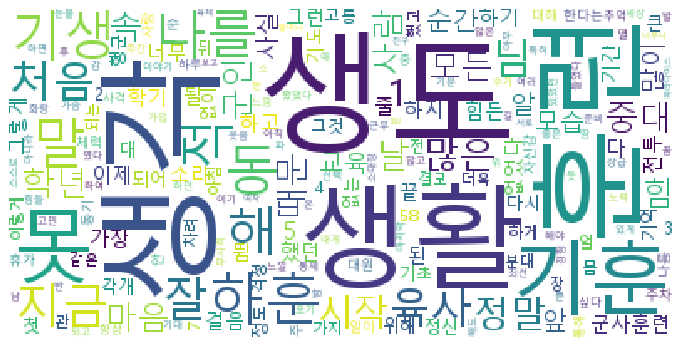

In [16]:
# 전체 문서의 주제 확인
data = nltk.Text(list(map(lambda t: t[0], tokens))).vocab().most_common()

wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf',
    relative_scaling=0.2,
    background_color='white'
).generate_from_frequencies(dict(data))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
tokens_ko = [
    [i for i in okt.pos(doc)
     if (
         (i[0] not in stopwords) and
         (i[1] not in ['Josa', 'Foreign', 'Punctuation', 'Alpha'])
     )]
    for doc in docs_ko
]

tokens_ko = [list(map(lambda t: '/'.join(t), tokens)) for tokens in tokens_ko]

In [53]:
# 추출한 전체 형태소로 토픽 분석

from gensim import corpora

dictionary_morphs = corpora.Dictionary(
#     list(map(lambda t: '/'.join(t), tokens))
    tokens_ko
)
dictionary_morphs.save('ko_morphs.dict')

In [54]:
len(dictionary_morphs)

4633

In [55]:
min_count = 5
word_counter = Counter(word for words in tokens_ko for word in words)
removal_word_idxs = {
    dictionary_morphs.token2id[word] for word, count in word_counter.items()
    if count < min_count
}
dictionary_morphs.filter_tokens(removal_word_idxs)
dictionary_morphs.compactify()

In [56]:
len(dictionary_morphs)

589

In [57]:
from gensim import models
tf_morphs = [dictionary_morphs.doc2bow(doc) for doc in tokens_ko]
tfidf_model_morphs = models.TfidfModel(tf_morphs)
tfidf_morphs = tfidf_model_morphs[tf_morphs]
corpora.MmCorpus.serialize('ko.mm', tfidf_morphs)

In [60]:
# 토픽 추출
from pprint import pprint

num_topics, num_words = 5, 30

lda_model = models.ldamodel.LdaModel(
    tfidf_morphs,
    id2word=dictionary_morphs,
    num_topics=num_topics,
)

pprint(
    lda_ko.print_topics(
        num_topics=num_topics, 
        num_words=num_words
    )
)

[(0,
  '0.005*"할머니/Noun" + 0.005*"육사/Noun" + 0.004*"삶/Noun" + 0.004*"길/Noun" + '
  '0.003*"땐/Noun" + 0.003*"체력/Noun" + 0.003*"분대/Noun" + 0.003*"로서/Noun" + '
  '0.003*"군인/Noun" + 0.003*"정말/Noun" + 0.003*"안/Noun" + 0.003*"했었다/Verb" + '
  '0.003*"좋았다/Adjective" + 0.003*"학기/Noun" + 0.003*"너무/Adverb" + '
  '0.003*"않고/Verb" + 0.003*"님/Suffix" + 0.003*"아직/Adverb" + 0.003*"열심히/Adverb" '
  '+ 0.003*"사실/Noun" + 0.003*"단련/Verb" + 0.003*"군사훈련/Noun" + 0.003*"하기/Verb" + '
  '0.003*"기초/Noun" + 0.003*"거/Noun" + 0.003*"생도/Noun" + 0.003*"기도/Noun" + '
  '0.003*"택/Noun" + 0.003*"되고/Verb" + 0.003*"상급/Noun"'),
 (1,
  '0.005*"파트너/Noun" + 0.004*"파생/Noun" + 0.004*"하훈/Noun" + 0.004*"건/Noun" + '
  '0.003*"행사/Noun" + 0.003*"추억/Noun" + 0.003*"문/Noun" + 0.003*"건물/Noun" + '
  '0.003*"길/Noun" + 0.003*"고민/Noun" + 0.003*"낙오/Noun" + 0.003*"같은/Adjective" + '
  '0.003*"아침/Noun" + 0.003*"의식/Noun" + 0.003*"시작/Noun" + 0.003*"날/Noun" + '
  '0.003*"마칠/Verb" + 0.003*"이제/Noun" + 0.003*"더욱/Noun" + 0.003*"매일/Noun" + '
  '0.003*"후배

In [61]:
def get_topic_term_prob(lda_model):
    topic_term_freqs = lda_model.state.get_lambda()
    topic_term_prob = topic_term_freqs / topic_term_freqs.sum(axis=1)[:, None]
    return topic_term_prob

In [62]:
print(lda_model.alpha.shape) # (n_topics,)
print(lda_model.alpha.sum()) # 1.0

topic_term_prob = get_topic_term_prob(lda_model)
print(topic_term_prob.shape)     # (n_topics, n_terms)
print(topic_term_prob[0].sum())  # 1.0

(5,)
1.0
(5, 589)
1.0


In [64]:
import pyLDAvis.gensim as gensimvis

prepared_data = gensimvis.prepare(
    lda_model,           # LDA Model
    tfidf_morphs,        # Corpus
    dictionary_morphs    # Dictionary
)

C:\Users\jinma\AppData\Local\Continuum\anaconda3\envs\basic\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [68]:
# pyLDAvis.display(prepared_data)

In [67]:
pyldavis_html_path = 'onesuncho_.html'
pyLDAvis.save_html(prepared_data, pyldavis_html_path)

# Implementation LDA

In [75]:
num_topics = 5
num_terms = 4000

In [77]:
# alpha만 고려, eta의 경우 단어만큼 생김!
name = 'alpha'
if name == 'alpha':
    prior_shape = num_topics
elif name == 'eta':
    prior_shape = num_terms

`isinstance(prior, six.string_types)`

In [85]:
# Symmetric == Auto
# Auto일 경우, optimized_{}를 True로 반환!
init_prior = np.fromiter(
    (1.0 / num_topics for _ in range(prior_shape)),
    dtype=np.finfo(np.float32).dtype, count=prior_shape
)
init_prior

array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32)

In [88]:
# Asymmetric
init_prior = np.fromiter(
    (1.0 / (i + np.sqrt(prior_shape)) for i in range(prior_shape)),
    dtype=np.finfo(np.float32).dtype, count=prior_shape
)
init_prior /= init_prior.sum()
init_prior

array([0.33283758, 0.22998512, 0.17569299, 0.14213862, 0.11934563],
      dtype=float32)

`isinstance(prior, list)`

In [91]:
prior = [0.2, 0.5, 0.1, 0.1, 0.1]
init_prior = np.asarray(prior, dtype=np.finfo(np.float32).dtype)
init_prior

array([0.2, 0.5, 0.1, 0.1, 0.1], dtype=float32)

`isinstance(prior, np.ndarray)`

In [93]:
prior = np.array([0.2, 0.3, 0.1, 0.2, 0.2])
init_prior = prior.astype(dtype=np.finfo(np.float32).dtype, copy=False)
init_prior

array([0.2, 0.3, 0.1, 0.2, 0.2], dtype=float32)

In [98]:
pow(2, 5)

32